<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/CI%26SL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project creator

**Creator**: [Dimitrios Papadopoulos](https://www.linkedin.com/in/jpapadopoulos/) 👾 <br>
**Email**: papadopoulos.v.dimitris@gmail.com <br>
**Academic email:** dpapadoac@csd.auth.gr<br>
**Date**: Dec 9th 2025 <br>
**Project**: Spectral Graph Analysis<br>

**If you can't see the graphs, feel free to reach me out, and I'll grant you the needed access.*



# Import libs

In [ ]:
#!pip uninstall -y cuml cudf cupy cupy-cuda12x numba pynvjitlink numba-cuda 2>/dev/null
#!pip install numba==0.60.0
#!pip install cupy-cuda12x
#!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.10.*

import os
os.environ["NUMBA_CUDA_ENABLE_PYNVJITLINK"] = "1"
os.environ["NUMBA_CUDA_LOW_OCCUPANCY_WARNINGS"] = "0"

from cuml.manifold import TSNE as cuTSNE
import cupy as cp

!pip uninstall tensorflow -y
!pip install tensorflow==2.16.1
!pip install --upgrade ml_dtypes tensorflow

import numpy as np
from numpy.linalg import eigh, eig, svd, norm, inv
from scipy.sparse import csr_matrix, diags, eye as sparse_eye
from scipy.sparse.linalg import eigsh, eigs
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse.csgraph import shortest_path


from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix,
    accuracy_score
)
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from enum import Enum, auto
import warnings
import time

warnings.filterwarnings('ignore')

# set random seeds globaly
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
  Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.9 MB)
Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached protobuf-4.25.8-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.2
    Uninstalling protobuf-6.33.2:
      Successfully uninstalled protobuf-6.33.2
  Attemptin

  Using cached ml_dtypes-0.5.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached protobuf-6.33.2-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached ml_dtypes-0.5.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (5.0 MB)
Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (620.7 MB)
Using cached protobuf-6.33.2-cp39-abi3-manylinux2014_x86_64.whl (323 kB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.8
    Uninstalling protobuf-4.25.8:
      Successfully uninstalled protobuf-4.25.8
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfu

# Configuration attributes

In [ ]:
@dataclass
class Config:

    # data
    sample_fraction: float = 0.85      # using x% of the data for faster experimenting
    normalize_method: str = 'minmax'   # avail options: 'minmax', 'standard'
    random_seed: int = 42

    # graph
    n_neighbors: int = 10 # k for kNN graph
    sigma: float = None   # gaussian kernel bandwidth (none = auto-estimate)

    # enable/disable methods
    enable_laplacian_eigenmaps: bool = True
    enable_lpp: bool = True
    enable_isomap: bool = True
    enable_lle: bool = True
    enable_tsne: bool = True

    # spectral settings
    n_clusters_list: List[int] = field(default_factory=lambda: [2, 3, 5, 7, 10])

    # tSNE only
    tsne_perplexity: float = 30.0
    tsne_n_iter: int = 1000


config = Config()

print(">>> Configuration set")
print(f"   Sample fraction: {config.sample_fraction * 100:.0f}%")
print(f"   n_neighbors: {config.n_neighbors}")
print(f"   Methods enabled: LE={config.enable_laplacian_eigenmaps}, LPP={config.enable_lpp}, "
      f"Isomap={config.enable_isomap}, LLE={config.enable_lle}, t-SNE={config.enable_tsne}")

>>> Configuration set
   Sample fraction: 85%
   n_neighbors: 10
   Methods enabled: LE=True, LPP=True, Isomap=True, LLE=True, t-SNE=True


# Data preprocessing

In [ ]:
def load_mnist():
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    class_names = [str(i) for i in range(10)]
    return x_train, y_train, x_test, y_test, class_names

def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train, y_test = y_train.flatten(), y_test.flatten()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return x_train, y_train, x_test, y_test, class_names

def sample_data(x, y, fraction, random_seed=RANDOM_SEED):
    from sklearn.model_selection import train_test_split

    x_sample, _, y_sample, _ = train_test_split(
        x, y,
        train_size=fraction,
        stratify=y, # enable stratification for fair representation
        random_state=random_seed
    )
    return x_sample, y_sample

def preprocess_data(x, y, config):
    # sample, flatten, normalize to [0,1].

    # handle 100% of data (skip sampling)
    if config.sample_fraction >= 1.0:
        x_sampled, y_sampled = x, y
    else:
        x_sampled, y_sampled = sample_data(x, y, config.sample_fraction, config.random_seed)

    # flatten and normalize (images are 0-255 move under scale to 0-1)
    x_flat = x_sampled.reshape(len(x_sampled), -1).astype(np.float32) / 255.0

    return x_flat, y_sampled

# Data loading

In [ ]:
# loading MNIST
print(">>> Loading MNIST")
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, mnist_classes = load_mnist()
x_mnist, y_mnist = preprocess_data(x_train_mnist, y_train_mnist, config)
print(f"MNIST: {x_mnist.shape[0]} samples, {x_mnist.shape[1]} features")

# loading CIFAR10
print(">>> Loading CIFAR10")
x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar, cifar_classes = load_cifar10()
x_cifar, y_cifar = preprocess_data(x_train_cifar, y_train_cifar, config)
print(f"CIFAR10: {x_cifar.shape[0]} samples, {x_cifar.shape[1]} features")

print(">>> Data loaded and preprocessed")

>>> Loading MNIST
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
MNIST: 51000 samples, 784 features
>>> Loading CIFAR10
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 67s 0us/step
CIFAR10: 42500 samples, 3072 features
>>> Data loaded and preprocessed


# Datasets visualization

In [ ]:
def visualize_samples(x_original, y, class_names, dataset_name, n_samples=5):
    # present sample images from each class
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, n_samples, figsize=(n_samples * 1.5, n_classes * 1.5))
    fig.suptitle(f'{dataset_name}: Sample Images', fontsize=14)

    for row, cls in enumerate(range(n_classes)):
        # get images of this class
        cls_indices = np.where(y == cls)[0]
        selected = np.random.choice(cls_indices, size=n_samples, replace=False)

        for col, idx in enumerate(selected):
            ax = axes[row, col]
            img = x_original[idx]

            # handling grayscale (MNIST) vs rbg (CIFAR10)
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)

            ax.axis('off')
            if col == 0:
                ax.set_title(class_names[cls], fontsize=10)

    plt.tight_layout()
    plt.show()



# visualize_samples(x_train_mnist, y_train_mnist, mnist_classes, 'MNIST')
print("\n\n")
# visualize_samples(x_train_cifar, y_train_cifar, cifar_classes, 'CIFAR10')

# Graph creation

In [ ]:
def build_knn_graph(x, n_neighbors):
    """
    finds k nearest neighbors for each point
    returning symmetric binary adjacency matrix
    mode -> connectivity: matrix should be binary (1: connection, 0: no connection)
    include_self: ensures a point is not considered its own neighbor
    """
    knn = kneighbors_graph(x, n_neighbors, mode='connectivity', include_self=False)

    # symmetric transformation:
    # if there's an edge from i to j or from j to i
    # it will be present in adjacency
    adjacency = knn + knn.T

    # if both i is neighbor of j and j is neighbor of i, then the entry will be 2
    # so I convert them to 1, or I keep them as 0 if it's 0 already
    adjacency = (adjacency > 0).astype(np.float64)

    return adjacency.toarray()

def compute_gaussian_weights(x, adjacency, sigma=None):
    """
    converts distances to similarities using Gaussian kernel
    compute Gaussian kernel weights (used formula from pdf)
    W_ij = exp(-||x_i - x_j||^2 / (2 * sigma^2))
    """
    distances = cdist(x, x, 'euclidean')

    # estimate sigma IF not provided (median)
    if sigma is None:

      # considers distances between points that are k nearest neighbors
        connected_distances = distances[adjacency > 0]

        # if sigma is none, will be calculated using distances' median
        sigma = np.median(connected_distances)

    # closer to 1: better similarity
    # closer to 0, the opposite
    W = np.exp(-distances**2 / (2 * sigma**2))

    # all the entries (where adjacency is 0) become 0
    # meaning non-neighbors have zero similarity
    W = W * adjacency
    np.fill_diagonal(W, 0)

    return W, sigma

def build_similarity_graph(x, n_neighbors, sigma=None):
    """
    combines both steps + computes degree matrix
    and then building complete similarity graph
    returning W (matrix), D (matrix) and which sigma used
    """
    adjacency = build_knn_graph(x, n_neighbors)
    W, sigma = compute_gaussian_weights(x, adjacency, sigma)
    D = np.diag(W.sum(axis=1))  # degree matrix

    return W, D, sigma

# Method 1: Laplacian Eigenmap [LE]

In [ ]:
def laplacian_eigenmaps(x, n_components=2, n_neighbors=15, sigma=None):
    """
    Laplacian Eigenmaps for dimensionality reduction:

    1. building similarity graph (W and D)
    2. calculating Laplacian L = D - W
    3. normalization with L_rows = D^(-1) @ L
    4. finding the actual eigenvectors
    5. returnin at the end the 2nd to (n_components+1)th eigenvectors
    """
    # 1: building similarity graph
    W, D, sigma = build_similarity_graph(x, n_neighbors, sigma)

    # 2: calculating Laplacian
    L = D - W

    # 3: normalization with (L_rows = D^(-1) @ L)

    # small value to avoid division by zero
    D_inv = np.diag(1.0 / (np.diag(D) + 1e-10))
    L_rows = D_inv @ L

    # 4: finding the actual eigenvectors
    eigenvalues, eigenvectors = eigh(L_rows)

    # sorting by eigenvalue and skip the first eigenvector (useless)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # 5: returnin at the end the 2nd to (n_components+1)th eigenvectors
    embedding = eigenvectors[:, 1:n_components + 1]

    return embedding, eigenvalues


print(">>> Laplacian Eigenmaps executed")

>>> Laplacian Eigenmaps executed


# Method 2: Locality Preserving Projections [LPP]

In [ ]:
def lpp(x, n_components=2, n_neighbors=15, sigma=None):
    """
    LPP - Linear approximation of Laplacian Eigenmaps

    key difference from LE:
    - LE gives embedding (positions)
    - LPP gives projection matrix (can project new data) - using Euclidean distances

    I want to solve the X @ L @ X.T @ w = λ @ X @ D @ X.T @ w
    formula was used after reading the following paper:
    https://proceedings.neurips.cc/paper/2003/file/d69116f8b0140cdeb1f99a4d5096ffe4-Paper.pdf
    """
    from scipy.linalg import eigh as scipy_eigh

    n_samples, n_features = x.shape

    # 1: building similarity graph (same as LE but for LPP this time)
    W, D, sigma = build_similarity_graph(x, n_neighbors, sigma)

    # 2: calculating Laplacian
    L = D - W

    # 3: calculating scatter matrices
    # X.T has shape (features, samples)
    # XLXT has shape (features, features)
    XLXT = x.T @ L @ x # (784, 784) - what relation exists through Laplacian
    XDXT = x.T @ D @ x # w will be (784,) a weight per feature - what relation exists through connectivity

    # 4: regularization (avoid singular matrix)
    # np.trace(XDXT) = sum of all diagonal elements (matrix size)
    reg = 1e-6 * np.trace(XDXT) / n_features # dividing with n_features to get the avg
    XDXT_reg = XDXT + reg * np.eye(n_features) # append to the diagonal

    # 5: fix generalized eigenvalue problem
    # scipy_eigh() is finding the values and vectors of an eigen
    # A*v = λ*B*v using this formula
    # vectors are the projection weights
    # values are the numbers telling me how good each weight is
    eigenvalues, eigenvectors = scipy_eigh(XLXT, XDXT_reg)

    # 6: find eigenvalues that are NOT near zero (skip meaningless ones)
    threshold = 1e-10
    valid_idx = np.where(eigenvalues > threshold)[0]

    # sort the valid eigenvalues (smallest first)
    valid_eigenvalues = eigenvalues[valid_idx]
    sorted_valid_idx = valid_idx[np.argsort(valid_eigenvalues)]

    # picks the 2 eigenvector columns that have the smallest valid eigenvalues for 2D result
    projection_matrix = eigenvectors[:, sorted_valid_idx[:n_components]]

    # 7: data projection
    """
            x                  projection_matrix                embedding
    | 15000 images    |       |   784 weights   |     =  | 15000 points in 2D |
    |                 |   X   |                 |        |                    |
    | with 784 pixels |       | for each of 2D  |        | (x, y) coordinates |
    """
    embedding = x @ projection_matrix

    return embedding, projection_matrix, eigenvalues


def lpp_project_new_data(x_new, projection_matrix):
    """
    projecting new data using learned LPP projection matrix - big diff from LE that needs to recalculate
    """
    return x_new @ projection_matrix


print(">>> LPP executed")

>>> LPP executed


# Method 3: Isometric Mapping [ISOMAP]

In [ ]:
def isomap(x, n_components=2, n_neighbors=15):
    """
    Isomap - Isometric Mapping

    Concept:
    - using Geodesic distance (along the surface) instead of Euclidean (straight line)
    - Good for "unfolding" curved data like "swiss roll"

    How it works:
    1. building a k-NN graph (connecting nearby points)
    2. calculating the shortest path between all pairs (approximates geodesic distance)
    3. applying MDS (multidimensional scaling) to preserve these distances in 2D

    the following paper was used:
    https://www.science.org/doi/10.1126/science.290.5500.2319
    """
    from sklearn.manifold import Isomap as SklearnIsomap

    model = SklearnIsomap(
        n_components=n_components,  # output dimensions (2 for 2D)
        n_neighbors=n_neighbors     # k in kNN graph
    )

    embedding = model.fit_transform(x)

    return embedding, model


print(">>> Isomap executed")

>>> Isomap executed


# Model 4: Locally Linear Embedding [LLE]

In [ ]:
def lle(x, n_components=2, n_neighbors=15):
    """
    LLE - Locally Linear Embedding

    Concept:
    - each point can be reconstructed as a weighted sum of its neighbors
    - finding 2D positions where the same weights still work
    - preserving local geometry without using distances

    How it works:
    1. for each point, find weights that reconstruct it from neighbors
       Point_i ≈ w1*Neighbor1 + w2*Neighbor2 + ... + wk*Neighbork
    2. finding 2D coordinates where these same weights still reconstruct each point

    Key difference from other methods:
    - LE/LPP: uses distances (Euclidean) → weights (Gaussian kernel)
    - Isomap: uses distances (Geodesic)
    - LLE: uses reconstruction weights directly (without distances)

    example:

    A(1, 1) | B(2, 4) | C(4, 1) | D(3, -1)

    for LE/LPP (after calc distances and using the W formula - random numbers)
      Wab = 0.29
      Wac = 0.32
      Wad = 0.37

    for LLE:
      A = w1*b + w2*c + w3*d => (1,1) = w1*(2,4) + w2*(4,1) + w3*(3,-1)
      constraints: w1+w2+w3=1 and I need to minimize the reconstruction error

      x; 1 = 2*w1 + 4*w2 + 3*w3
      y; 1 = 4*w1 + 1*w2 + -1*w3
      constraint; 1 = w1+w2+w3

      result: w1 = 0.1, w2 = 0.6, w3 = 0.3

    does that mean C is the best with 0.6? Not really, this is not about calculating distance
    but gives a weight on the point that could help the reconstruction of the code point (in this case A)

    the following paper was used:
    https://www.science.org/doi/10.1126/science.290.5500.2323
    """
    from sklearn.manifold import LocallyLinearEmbedding

    model = LocallyLinearEmbedding(
        n_components=n_components,  # output dimensions (2 for 2D)
        n_neighbors=n_neighbors,    # k neighbors for reconstruction
        method='standard'           # standard LLE algorithm (other options: modified, hessian, ltsa)
    )

    embedding = model.fit_transform(x)

    return embedding, model


print(">>> LLE executed")

>>> LLE executed


# Model 5: t-Distributed Stochastic Neighbor Embedding [tSNE]

In [ ]:
#!pip install cuml-cu11 cupy-cuda11x

def tsne(x, n_components=2, perplexity=30.0, n_iter=1000):
    """
    t-SNE using GPU
    """
    from cuml.manifold import TSNE as cuTSNE
    import cupy as cp

    print("   Running t-SNE on ...")

    x_gpu = cp.asarray(x, dtype=cp.float32)

    model = cuTSNE(
        n_components=n_components,
        perplexity=perplexity,
        n_iter=n_iter,
        random_state=42
    )

    embedding_gpu = model.fit_transform(x_gpu)
    embedding = cp.asnumpy(embedding_gpu)

    return embedding, model


print(">>> t-SNE executed")



"""
CPU mode below
"""

# def tsne(x, n_components=2, perplexity=30.0, n_iter=10000):
#     """
#     t-SNE - t-Distributed Stochastic Neighbor Embedding

#     Concept:
#     - converting distances to probs (simply as "what's the chance point A picks point B as neighbor?")
#     - finding 2D embedding where these probs match as closely as possible
#     - creating the best visualization with clear cluster separation

#     How it works:
#     1. if there's high-D: compute prob that point i would pick point j as neighbor (Gaussian)
#     2. if there's low-D: compute same prob (Student-t distribution)
#     3. minimize the difference between these two prob distributions

#     What about Student-t in low-D?
#     - it has "heavier tails" than Gaussian
#     - allowing distant points to spread out more in 2D
#     - preventing the "crowding problem" (everything squished together)

#     Important!
#     - perplexity: this attribute defines roughly "how many neighbors to consider"

#     the following paper was used:
#     https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
#     """
#     from sklearn.manifold import TSNE

#     model = TSNE(
#         n_components=n_components,  # output dimensions (2 for 2D)
#         perplexity=perplexity,      # ~number of neighbors (default 30, typically something between 5-50)
#         n_iter=n_iter,              # optimization iterations
#         random_state=42             # for reproducibility
#     )

#     embedding = model.fit_transform(x)

#     return embedding, model


# print(">>> t-SNE executed")

>>> t-SNE executed


'\nCPU mode below\n'

# Spectral Clustering

In [ ]:
def spectral_clustering(x, n_clusters, n_neighbors=15):
    """
    Spectral Clustering - groups data into clusters using graph structure

    How it works:
    1. building similarity graph (like for LE)
    2. computing Laplacian eigenvectors
    3. using eigenvectors as new features
    4. applying k means on these features

    Important:
    for MNIST I know there are 10 classes, so I will expect 10 clusters
    if the class number is unknown, then I will have to experiment with the
    clusters number and find the appropriate outcome

    """
    from sklearn.cluster import SpectralClustering

    model = SpectralClustering(
        n_clusters=n_clusters,          # how many groups to create (comment above)
        affinity='nearest_neighbors',   # use kNN graph
        n_neighbors=n_neighbors,        # k of kNN
        random_state=42
    )

    # building graph, computing eigenvectors, running k means, and last returning labels
    cluster_labels = model.fit_predict(x)

    return cluster_labels, model

    print(">>> Spectral Clustering executed")

# Spectral Clustering Evaluation

In [ ]:
def evaluate_clustering(true_labels, cluster_labels):
    """
    Evaluating how good the clustering is by comparing to true labels

    Metrics:
    - ARI (Adjusted Rand Index): -1 to 1, higher = better, 0 = random
    - NMI (Normalized Mutual Info): 0 to 1, higher = better
    - Homogeneity: if a cluster of digit x includes dots of another digit y, then it's not homogeneity
    - Completeness: if all dots of a class exist in the same cluster and nothing is missing, it's complete
    """

    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score

    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)

    return {
        'ARI': ari,
        'NMI': nmi,
        'Homogeneity': homogeneity,
        'Completeness': completeness
    }

    print(">>> Evaluation of Spectral Clustering executed")

# Results Visualization

In [ ]:
def plot_clustering_metrics_combined(df_results, n_clusters_list):
    """
    line graph (trends) + grouped bar chart (comparison)

    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    ax1 = axes[0]
    ax1.plot(df_results['n_clusters'], df_results['ARI'],           'o-', label='ARI',          linewidth=2, markersize=8)
    ax1.plot(df_results['n_clusters'], df_results['NMI'],           's-', label='NMI',          linewidth=2, markersize=8)
    ax1.plot(df_results['n_clusters'], df_results['Homogeneity'],   '^-', label='Homogeneity',  linewidth=2, markersize=8)
    ax1.plot(df_results['n_clusters'], df_results['Completeness'],  'd-', label='Completeness', linewidth=2, markersize=8)

    ax1.set_xlabel('num of clusters (k)')
    ax1.set_ylabel('score')
    ax1.set_title('Trends: metrics vs num of clusters')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(n_clusters_list)

    ax2 = axes[1]

    x = np.arange(len(n_clusters_list))
    width = 0.2
    metrics = ['ARI', 'NMI', 'Homogeneity', 'Completeness']
    colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple']

    for i, (metric, color) in enumerate(zip(metrics, colors)):
        offset = (i - 1.5) * width
        bars = ax2.bar(x + offset, df_results[metric], width, label=metric, color=color)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    ax2.set_xlabel('num of clusters (k)')
    ax2.set_ylabel('score')
    ax2.set_title('Comparison: metrics by num of clusters')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'k={k}' for k in n_clusters_list])
    ax2.legend(loc='upper left')
    ax2.set_ylim(0, 1.15)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


print(">>> Results Visualization executed")

>>> Results Visualization executed


In [ ]:
def plot_clusters_on_embedding(embedding, n_clusters_list, n_neighbors=15):
    """
    showing how spectral clustering divides the space for different k values
    """
    n_plots = len(n_clusters_list)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

    for ax, k in zip(axes, n_clusters_list):
        cluster_labels, _ = spectral_clustering(embedding, n_clusters=k, n_neighbors=n_neighbors)

        scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                            c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
        ax.set_title(f'spectral clustering: k={k}')
        ax.set_xlabel('comp 1')
        ax.set_ylabel('comp 2')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_true_vs_predicted(embedding, y_true, n_clusters, n_neighbors=15):
    """
    comparing ground truth labels with clustering results
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # left side, true labels
    scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1],
                               c=y_true, cmap='tab10', s=5, alpha=0.7)
    axes[0].set_title('true labels (Digits 0-9)')
    axes[0].set_xlabel('comp 1')
    axes[0].set_ylabel('comp 2')
    plt.colorbar(scatter1, ax=axes[0], label='Digit')
    axes[0].grid(True, alpha=0.3)

    # right side, cluster assignments
    cluster_labels, _ = spectral_clustering(embedding, n_clusters=n_clusters, n_neighbors=n_neighbors)
    scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1],
                               c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
    axes[1].set_title(f'spectral clustering (k={n_clusters})')
    axes[1].set_xlabel('comp 1')
    axes[1].set_ylabel('comp 2')
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# MNIST Execution Pipeline

In [ ]:
def run_mnist_pipeline(config):
    """
    dimensionality reduction + spectral clustering on MNIST.
    enable/disable methods via config flags.
    """
    embeddings = {}

    x_train, y_train, _, _, _ = load_mnist()
    x_data, y_data = preprocess_data(x_train, y_train, config)
    print(f"   {x_data.shape[0]} samples, {x_data.shape[1]} features\n")

    # dimensionality reduction methods
    methods = {
        'Laplacian Eigenmaps':  (config.enable_laplacian_eigenmaps, lambda: laplacian_eigenmaps (x_data, 2, config.n_neighbors)[0]),
        'LPP':                  (config.enable_lpp,                 lambda: lpp                 (x_data, 2, config.n_neighbors)[0]),
        'Isomap':               (config.enable_isomap,              lambda: isomap              (x_data, 2, config.n_neighbors)[0]),
        'LLE':                  (config.enable_lle,                 lambda: lle                 (x_data, 2, config.n_neighbors)[0]),
        't-SNE':                (config.enable_tsne,                lambda: tsne                (x_data, 2, config.tsne_perplexity, config.tsne_n_iter)[0])
    }

    for name, (enabled, method) in methods.items():
        if enabled:
            print(f"   ▶ {name}...")
            embeddings[name] = method()

    # visualize embeddings
    n_methods = len(embeddings)
    cols = min(3, n_methods)
    rows = (n_methods + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = np.array(axes).flatten() if n_methods > 1 else [axes]

    for idx, (name, emb) in enumerate(embeddings.items()):
        ax = axes[idx]
        scatter = ax.scatter(emb[:, 0], emb[:, 1], c=y_data, cmap='tab10', s=5, alpha=0.7)
        ax.set_title(name)
        ax.set_xlabel('comp 1')
        ax.set_ylabel('comp 2')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Digit')

    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('MNIST: Dimensionality Reduction Methods', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # spectral clustering: using t-SNE if available, else first available
    cluster_emb = embeddings.get('t-SNE', list(embeddings.values())[0])

    results = []
    for k in config.n_clusters_list:
        labels, _ = spectral_clustering(cluster_emb, k, config.n_neighbors)
        scores = evaluate_clustering(y_data, labels)
        scores['n_clusters'] = k
        results.append(scores)
        print(f"   k={k}: ARI={scores['ARI']:.3f}, NMI={scores['NMI']:.3f}")

    # visualize clustering results
    import pandas as pd
    df_results = pd.DataFrame(results)
    plot_clustering_metrics_combined(df_results, config.n_clusters_list)
    plot_clusters_on_embedding(cluster_emb, [2, 5, 10], config.n_neighbors)
    plot_true_vs_predicted(cluster_emb, y_data, 10, config.n_neighbors)

    return embeddings, df_results, y_data


print(">>> MNIST Pipeline executed")

>>> MNIST Pipeline executed


# CIFAR10 Execution Pipeline

In [ ]:
def run_cifar10_pipeline(config):
    """
    dimensionality reduction + spectral clustering on CIFAR10.
    enable/disable methods via config flags.
    """
    embeddings = {}

    x_train, y_train, _, _, _ = load_cifar10()
    x_data, y_data = preprocess_data(x_train, y_train, config)
    print(f"   {x_data.shape[0]} samples, {x_data.shape[1]} features\n")

    # dimensionality reduction methods
    methods = {
        'Laplacian Eigenmaps':  (config.enable_laplacian_eigenmaps, lambda: laplacian_eigenmaps (x_data, 2, config.n_neighbors)[0]),
        'LPP':                  (config.enable_lpp,                 lambda: lpp                 (x_data, 2, config.n_neighbors)[0]),
        'Isomap':               (config.enable_isomap,              lambda: isomap              (x_data, 2, config.n_neighbors)[0]),
        'LLE':                  (config.enable_lle,                 lambda: lle                 (x_data, 2, config.n_neighbors)[0]),
        't-SNE':                (config.enable_tsne,                lambda: tsne                (x_data, 2, config.tsne_perplexity, config.tsne_n_iter)[0])
    }

    for name, (enabled, method) in methods.items():
        if enabled:
            print(f"   ▶ {name}...")
            embeddings[name] = method()

    # visualize embeddings
    n_methods = len(embeddings)
    cols = min(3, n_methods)
    rows = (n_methods + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = np.array(axes).flatten() if n_methods > 1 else [axes]

    for idx, (name, emb) in enumerate(embeddings.items()):
        ax = axes[idx]
        scatter = ax.scatter(emb[:, 0], emb[:, 1], c=y_data, cmap='tab10', s=5, alpha=0.7)
        ax.set_title(name)
        ax.set_xlabel('comp 1')
        ax.set_ylabel('comp 2')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Class')

    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('CIFAR-10: Dimensionality Reduction Methods', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # spectral clustering: using t-SNE if available, else first available
    cluster_emb = embeddings.get('t-SNE', list(embeddings.values())[0])

    results = []
    for k in config.n_clusters_list:
        labels, _ = spectral_clustering(cluster_emb, k, config.n_neighbors)
        scores = evaluate_clustering(y_data, labels)
        scores['n_clusters'] = k
        results.append(scores)
        print(f"   k={k}: ARI={scores['ARI']:.3f}, NMI={scores['NMI']:.3f}")

    # visualize clustering results
    import pandas as pd
    df_results = pd.DataFrame(results)
    plot_clustering_metrics_combined(df_results, config.n_clusters_list)
    plot_clusters_on_embedding(cluster_emb, [2, 5, 10], config.n_neighbors)
    plot_true_vs_predicted(cluster_emb, y_data, 10, config.n_neighbors)

    return embeddings, df_results, y_data


print(">>> CIFAR10 Pipeline executed")

>>> CIFAR10 Pipeline executed


# Main




>>> MNIST Pipeline ...



   51000 samples, 784 features

   ▶ Laplacian Eigenmaps...
   ▶ LPP...
   ▶ Isomap...
   ▶ LLE...
   ▶ t-SNE...
   Running t-SNE on ...
[2026-01-06 19:49:57.080] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


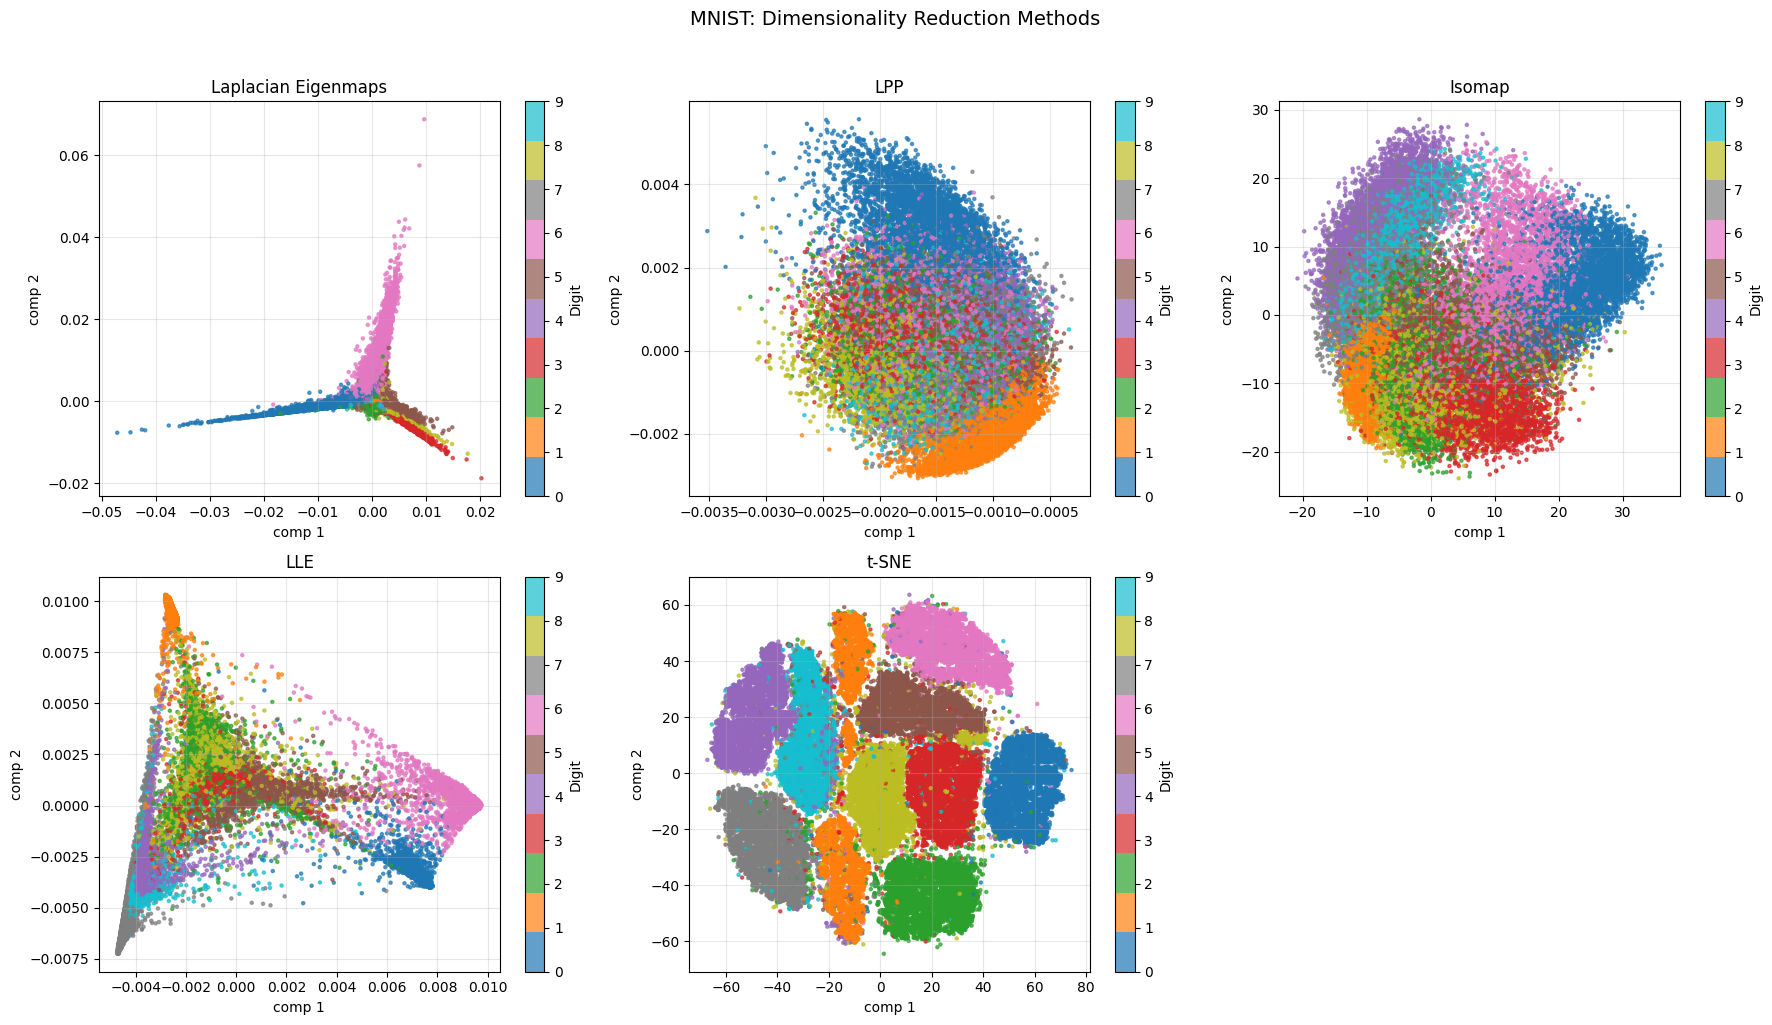

   k=2: ARI=-0.000, NMI=0.001
   k=3: ARI=0.161, NMI=0.358
   k=5: ARI=0.359, NMI=0.572
   k=7: ARI=0.469, NMI=0.651
   k=10: ARI=0.599, NMI=0.743


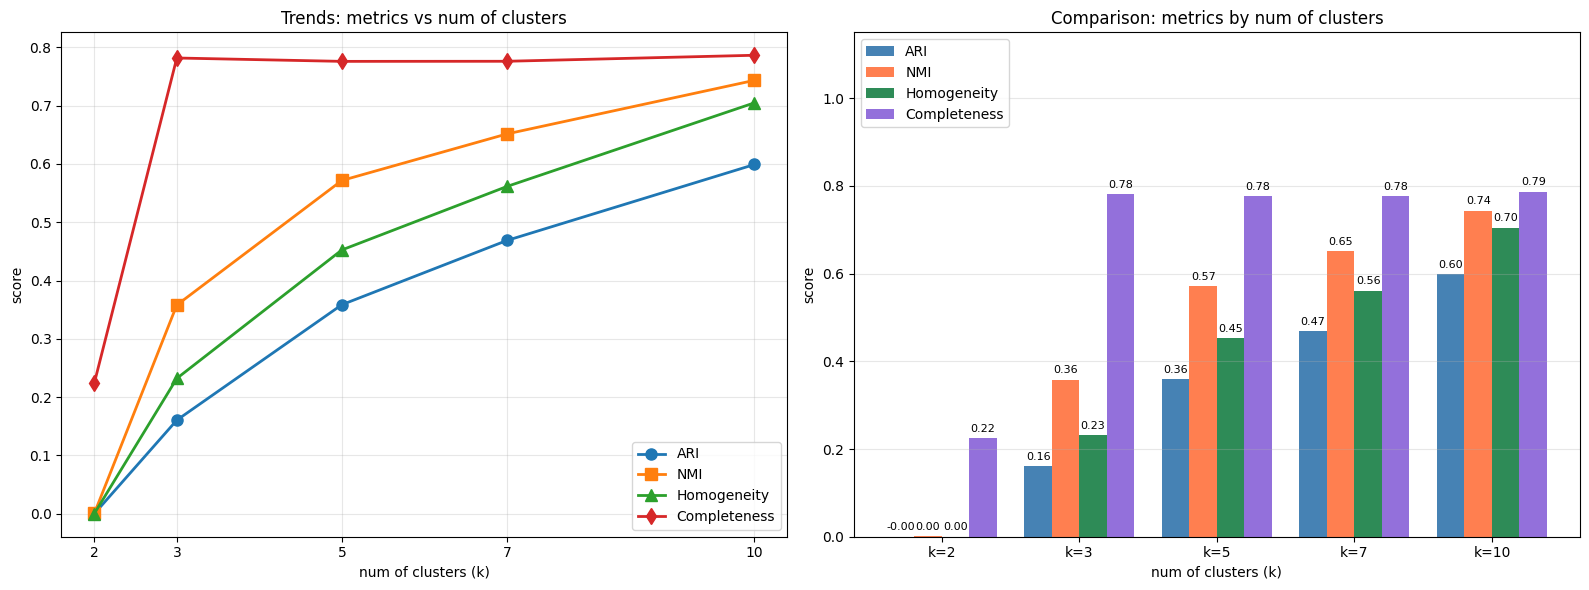

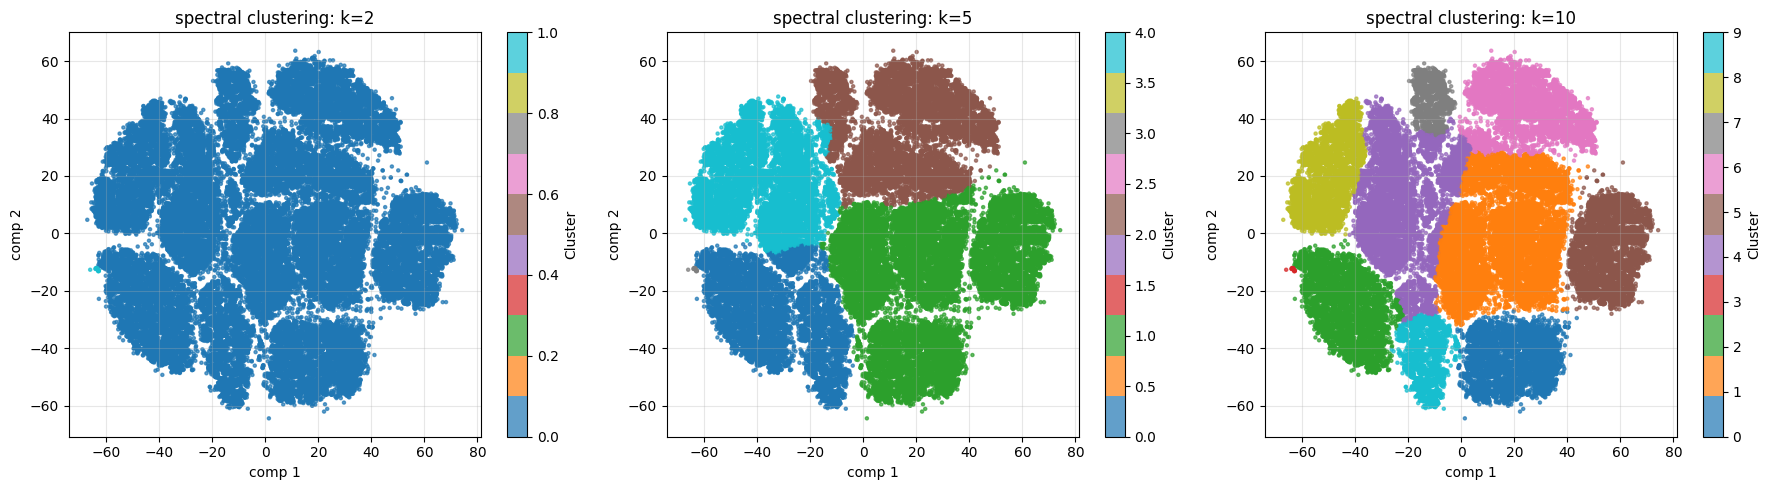

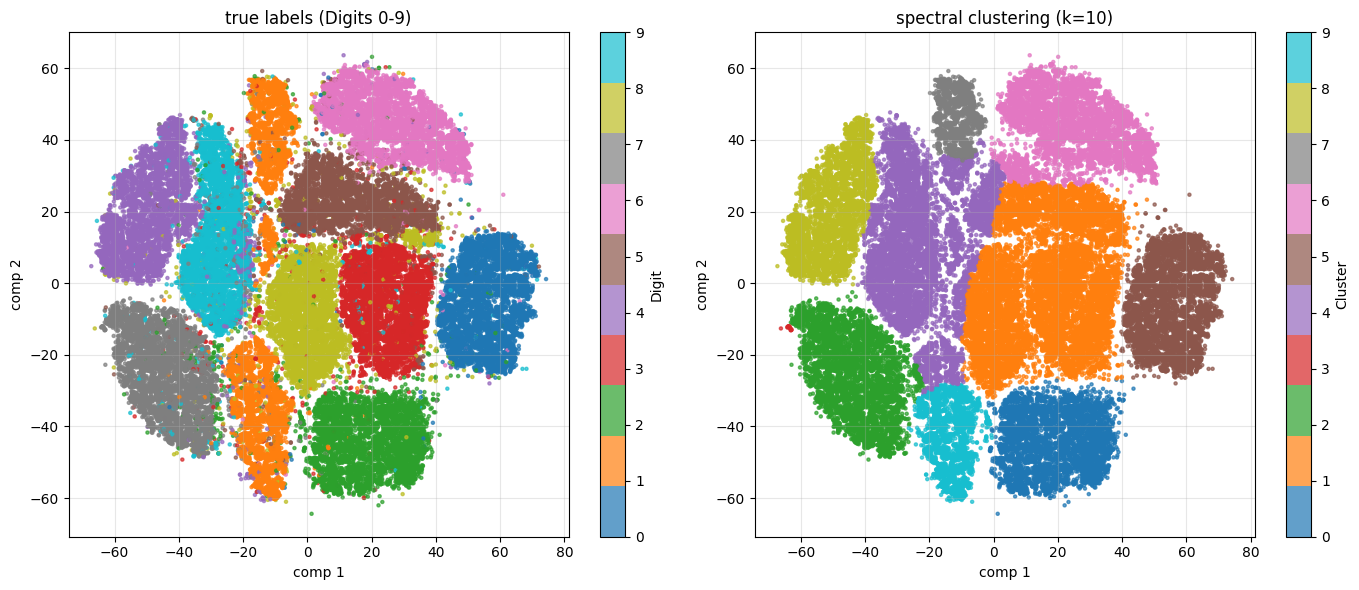




>>> CIFAR Pipeline ...



   42500 samples, 3072 features

   ▶ Laplacian Eigenmaps...
   ▶ LPP...
   ▶ Isomap...
   ▶ LLE...
   ▶ t-SNE...
   Running t-SNE on ...
[2026-01-07 01:16:01.723] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


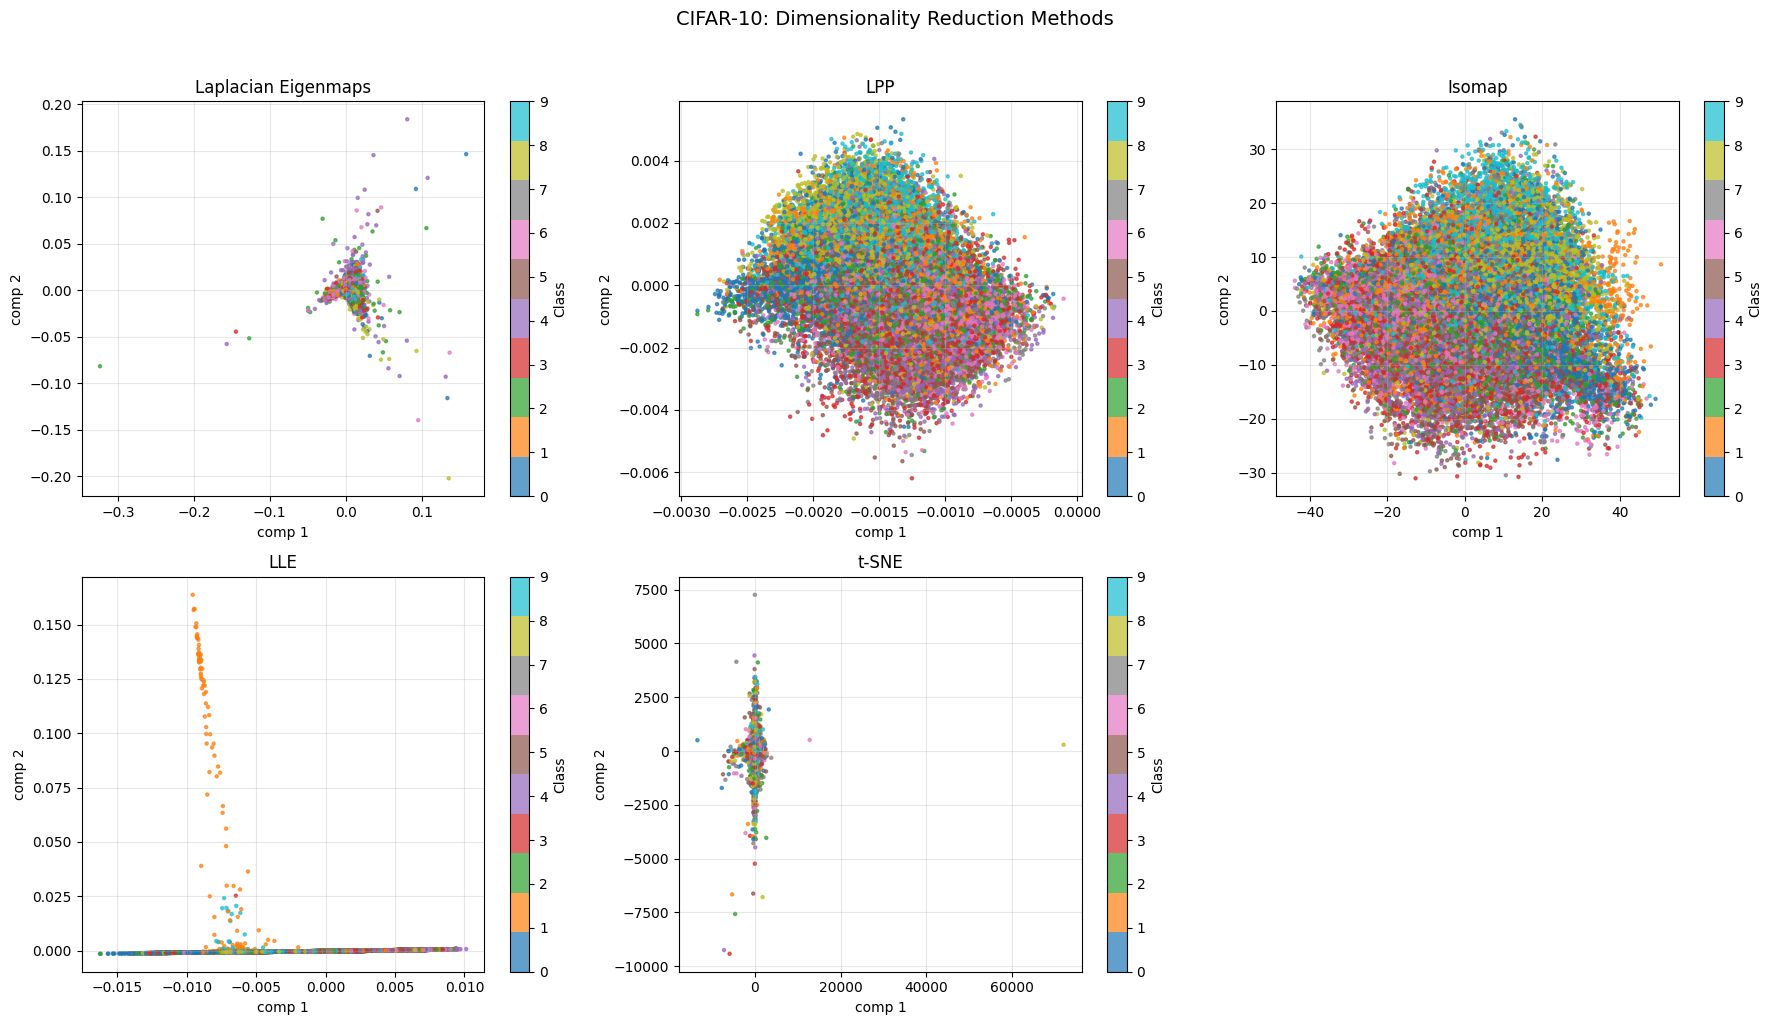

   k=2: ARI=0.000, NMI=0.000
   k=3: ARI=0.000, NMI=0.001
   k=5: ARI=0.001, NMI=0.004
   k=7: ARI=0.001, NMI=0.003
   k=10: ARI=0.001, NMI=0.004


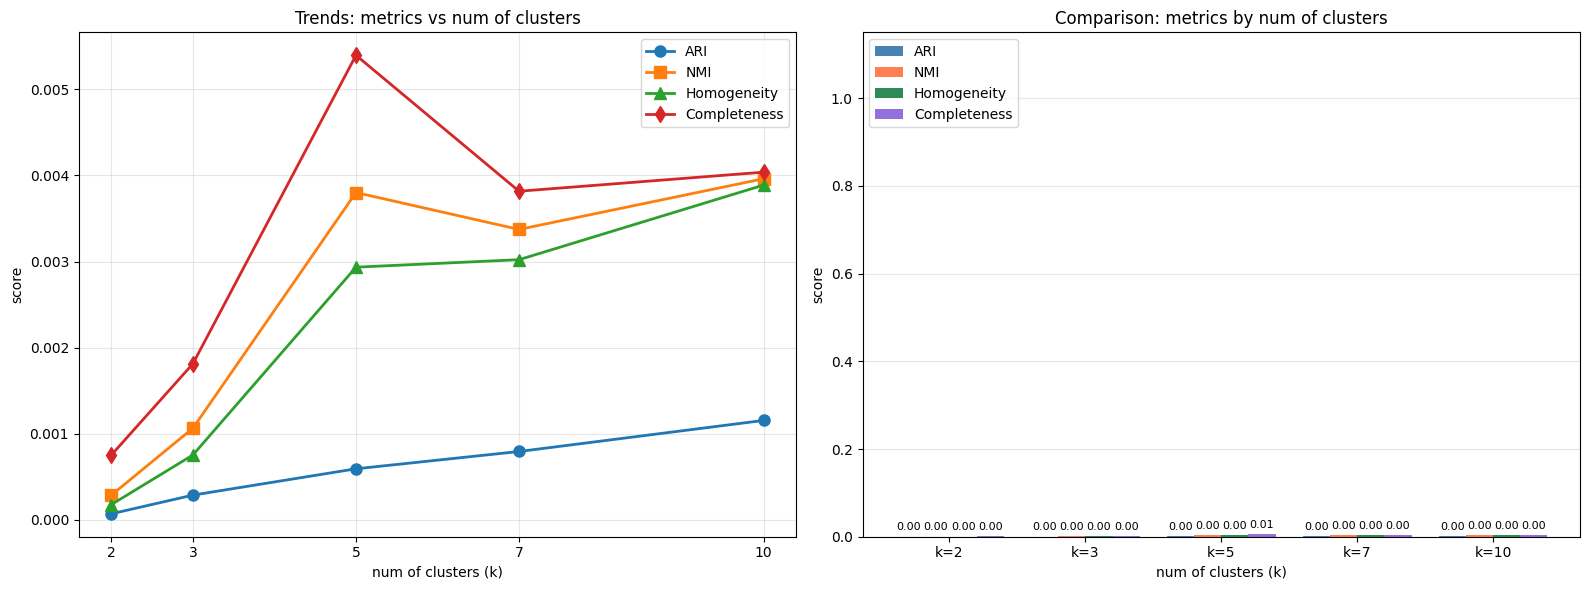

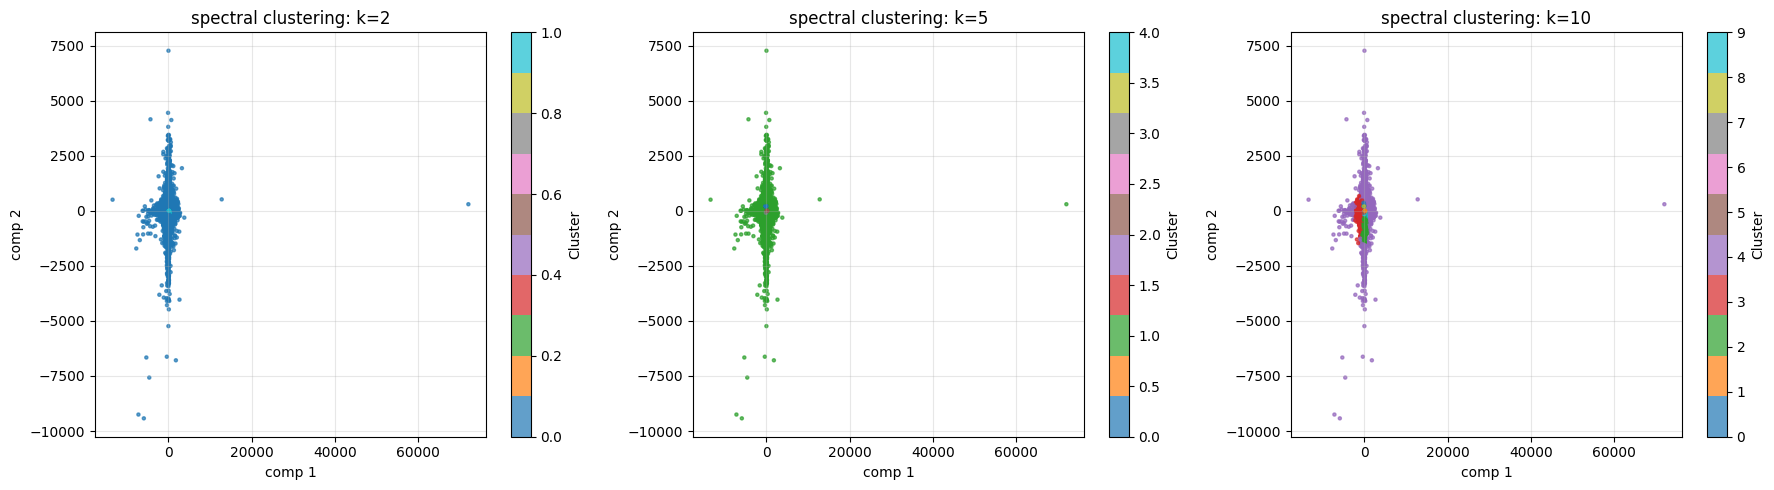

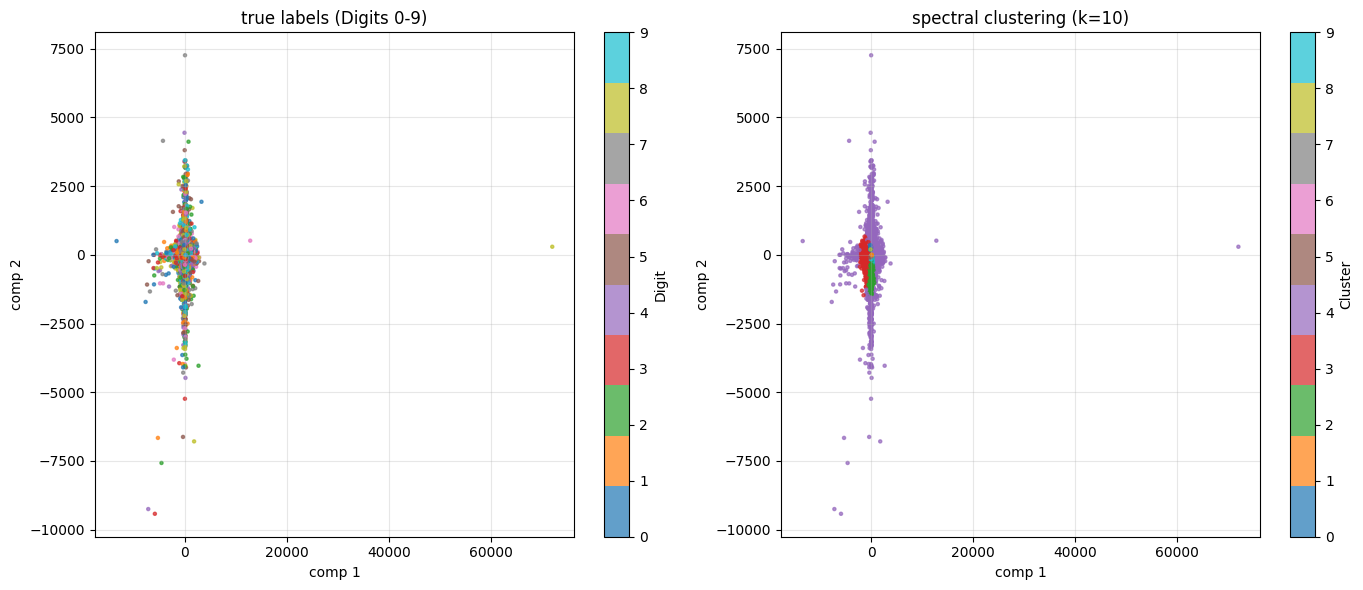

In [ ]:
print("\n\n")

print(">>> MNIST Pipeline ...")

print("\n\n")

embeddings_mnist, results_mnist, y_mnist = run_mnist_pipeline(config)

print("\n\n")

print(">>> CIFAR Pipeline ...")

print("\n\n")

embeddings_cifar, results_cifar, y_cifar = run_cifar10_pipeline(config)

# Results summary

# Εισαγωγη

Παρακατω θα αναλυσω την αποδοση μεθοδων μειωσης διαστασεων βασισμενων σε γραφους, ακολουθουμενων απο φασματικη ομαδοποιηση, σε δυο συνολα δεδομενων αναφορας: το MNIST (χειρογραφα ψηφια) και το CIFAR-10 (φυσικες εικονες).

Οι μεθοδοι που υλοποιηθηκαν περιλαμβανουν τις Laplacian Eigenmaps (LE), Locality Preserving Projections (LPP), Isomap, Locally Linear Embedding (LLE) και t-SNE. Μετα τη μειωση διαστασεων σε 2D, εφαρμοστηκε φασματικη ομαδοποιηση με διαφορετικο αριθμο clusters (k = 2, 3, 5, 7, 10).

Η βασικη μεθοδολογια ακολουθει τις αρχες που καθιερωθηκαν στο υλικο του μαθηματος, δηλαδη την κατασκευη ενος γραφου ομοιοτητας απο τα δεδομενα, τον υπολογισμο του Λαπλασιανου του γραφου, και την χρηση των ιδιοδιανυσματων του τοσο για μειωση διαστασεων οσο και για ομαδοποιηση.



# Πειραματα

## Δεδομενα

Το MNIST αποτελειται απο 60.000 ασπρομαυρες εικονες (χειρογραφες) ψηφιων (0-9), οπου καθε εικονα εχει ενα 784-διαστατο διανυσμα (28×28 pixels). Χρησιμοποιησα το 85% του συνολου δεδομενων (51.000 δειγματα), διοτι ολες οι μεθοδολογιες εκαναν πολυ χρονο, και καποιες 'εσκαγαν' σε πολλα iterations.

Το CIFAR-10 αποτελειται απο 50.000 εγχρωμες εικονες 10 κατηγοριων αντικειμενων (αεροπλανο, αυτοκινητο, πουλι, γατα κλπ.), οπου καθε εικονα εχει ενα 3.072-διαστατο διανυσμα (32×32×3 pixels). Χρησιμοποιησα το 85% του συνολου δεδομενων (42.500 δειγματα) για τον ιδιο λογο που ανεφερα και στο MNIST.

## Μεθοδοι

Ολες οι μεθοδοι βασιζονται στην κατασκευη ενος γραφου k κοντινοτερων γειτονων, ο οποιος οπως αναφερεται στο υλικο του μαθηματος, "πρεπει να ειναι η πρωτη επιλογη" για την κατασκευη γραφου ομοιοτητας διοτι "ειναι αραιος και μπορει να μοντελοποιησει δεδομενα σε διαφορετικες κλιμακες."

Οσον αφορα τις μεθοδους μειωσης διαστασεων:

Οι **Laplacian Eigenmaps** κατασκευαζουν το Laplacian του γραφου L = D - W και επιλυουν το γενικευμενο προβλημα ιδιοτιμων Lf = λDf. Ετσι **τα ιδιοδιανυσματα με τις μικροτερες ιδιοτμες μου δινουν τις νεες 2D** συντεταγμενες **διατηρωντας ομως τα γειτονικα σημεια** κοντα, **χωρις να χανω τετοια πληροφορια απο την μετατροπη**.

Η **LPP** (*Locality Preserving Projections*) ειναι η **γραμμικη εκδοση των Laplacian Eigenmaps**. Η βασικη διαφορα ειναι οτι οι Laplacian Eigenmaps βρισκουν απευθειας τις νεες συντεταγμενες καθε σημειου, ενω η LPP βρισκει εναν πινακα προβολης W που μπορει να εφαρμοστει σε οποιοδηποτε σημειο (x_new = W'x). Αυτο σημαινει οτι η LPP **μπορει να μετασχηματισει νεα δεδομενα που δεν ειχε δει κατα την εκπαιδευση**, ενω οι Laplacian Eigenmaps δεν μπορουν, ετσι η LPP μπορει να γενικευει δεδομενα που βλεπει για πρωτη φορα και δεν χρειαζεται να εκπαιδευτει με ολα τα δεδομενα ξανα απο την αρχη (μαζι με τα νεα).

Η **Isomap** (*Isometric Mappineg*) αντιμετωπιζει ενα βασικο προβλημα της Ευκλειδειας αποστασης. Σε καμπυλες, η ευθεια γραμμη μεταξυ δυο σημειων μπορει να "κοβει" μεσα απο περιοχες που δεν ανηκουν στα δεδομενα. Για παραδειγμα, σε ενα σχημα "S", δυο σημεια στα δυο ακρα μπορει να φαινονται κοντα στον 3D χωρο, αλλα για να πας απο το ενα στο αλλο ακολουθωντας την επιφανεια πρεπει να διανυσεις ολοκληρο το "S". Η Isomap λυνει αυτο το προβλημα χρησιμοποιωντας Geodesic αποστασεις, δηλαδη τις συντομοτερες διαδρομες κατα μηκος του γραφου k-κοντινοτερων γειτονων (υπολογισμενες με τον αλγοριθμο Dijkstra). Στη συνεχεια, εφαρμοζει κλασικη πολυδιαστατη κλιμακωση (MDS) σε αυτες τις Geodesic αποστασεις για να βρει τις νεες συντεταγμενες χαμηλων διαστασεων.

Η **LLE** (*Locally Linear Embedding*) βασιζεται σε μια απλη ιδεα, αυτη στην οποια καθε σημειο μπορει να περιγραφει προσεγγιστικα ως ενας σταθμισμενος μεσος ορος των γειτονων του. Ο αλγοριθμος δουλευει σε δυο βηματα. Πρωτο, για καθε σημειο βρισκει τα βαρη που δειχνουν ποσο συμβαλλει ο καθε γειτονας στην ανακατασκευη του. Δευτερον, βρισκει νεες συντεταγμενες σε χαμηλοτερες διαστασεις που διατηρουν αυτα τα ιδια βαρη. Η λογικη ειναι οτι αν τοπικα η πολλαπλοτητα (manifold) μοιαζει με επιπεδο, τοτε οι σχεσεις μεταξυ γειτονων θα παραμεινουν ιδιες και στη νεα αναπαρασταση.

Η **t-SNE** (*t-distributed Stochastic Neighbor Embedding*) προσεγγιζει το προβλημα διαφορετικα απο τις αλλες μεθοδους. Αντι να δουλευει απευθειας με αποστασεις, τις μετατρεπει σε πιθανοτητες. Ετσι, αν δυο σημεια ειναι κοντα, η πιθανοτητα να ειναι "γειτονες" ειναι υψηλη, ενω αν ειναι μακρια, η πιθανοτητα ειναι χαμηλη. Ο αλγοριθμος δημιουργει αυτες τις πιθανοτητες τοσο στον αρχικο υψηλοδιαστατο χωρο οσο και στον νεο χωρο χαμηλων διαστασεων, και προσπαθει να τις κανει οσο πιο ομοιες γινεται. Το αποτελεσμα ειναι οτι σημεια που ηταν κοντα στον αρχικο χωρο παραμενουν κοντα και στην οπτικοποιηση, ενω σημεια που ηταν μακρια τεινουν να μενουν μακρια. Η t-SNE ειναι ιδιαιτερα καλη στο να αναδεικνυει clusters στα δεδομενα.

Η φασματικη ομαδοποιηση ακολουθει τον αλγοριθμο του μαθηματος: πρωτον κατασκευη γραφου ομοιοτητας, δευτερον υπολογισμος των πρωτων k ιδιοδιανυσματων του Λαπλασιανου του γραφου, και τριτον χρηση k-means στα ενσωματωμενα σημεια.

## Αξιολογηση

Η αξιολογηση εγινε ανα σετ δεδομενων:

<br>

1.   MNIST:

- Για k=2 clusters, ο ARI ειναι -0.000 και ο NMI ειναι 0.001.
- Για k=3 clusters, ο ARI ειναι 0.161 και ο NMI ειναι 0.358.
- Για k=5 clusters, ο ARI ειναι 0.359 και ο NMI ειναι 0.572.
- Για k=7 clusters, ο ARI ειναι 0.469 και ο NMI ειναι 0.651.
- Για k=10 clusters, ο ARI ειναι 0.599 και ο NMI ειναι 0.743.

Οσον αφορα τις παρατηρησεις για τη μειωση διαστασεων, η ενσωματωση t-SNE παραγει σαφως διαχωρισμενες clusters που αντιστοιχουν στις 10 κατηγοριες ψηφιων. Η Isomap επισης δειχνει καλο διαχωρισμο με καποια επικαλυψη. Οι Laplacian Eigenmaps και η LLE δειχνουν μερικη δομη αλλα με περισσοτερη επικαλυψη απ οτι η Isomap. Η LPP, γραμμικη μεθοδος, παραγει μια συμπιεσμενη ενσωματωση με πολυ μικρο διαχωρισμο, επομενως δεν ειναι μια μεθοδος που βοηθαει και ιδιαιτερα.

<br>

2.   CIFAR-10:

- Για k=2 clusters, ο ARI ειναι 0.000 και ο NMI ειναι 0.000.
- Για k=3 clusters, ο ARI ειναι 0.000 και ο NMI ειναι 0.001.
- Για k=5 clusters, ο ARI ειναι 0.001 και ο NMI ειναι 0.004.
- Για k=7 clusters, ο ARI ειναι 0.001 και ο NMI ειναι 0.003.
- Για k=10 clusters, ο ARI ειναι 0.001 και ο NMI ειναι 0.004.

Οσον αφορα τις παρατηρησεις για τη μειωση διαστασεων, ολες οι μεθοδοι αποτυγχανουν να παραγουν ουσιαστικη δομη διακριτων clusters. Η ενσωματωση t-SNE δειχνει ολα τα σημεια συμπτυγμενα σε μια ενιαια μαζα με διασκορπισμενα ακραια σημεια. Οι Laplacian Eigenmaps παραγουν μια εκφυλισμενη ενσωματωση. Isomap και LPP παροτι εχουν εντελως διαφορετικο τροπο υπολογισμου, εχουν παρομοια αποτελεσματα. Αυτο και μονο δεχινει οτι εχει καποιο χαρ/κο το dataset που δεν επιτρεπει στις μεθοδολογιες αυτες να αποτυπωσουν ορθως και διακριτα τα clusters.



# Το MNIST ειχε θετικα αποτελεσματα, ενω το CIFAR-10 οχι. Γιατι;


## Αναφορικα με την υποθεση της Πολλαπλοτητας (Manifold Hypothesis)

Οι μεθοδοι βασισμενες σε γραφους στηριζονται στην υποθεση της πολλαπλοτητας. Αυτη λεει οτι τα δεδομενα καθε κατηγοριας σχηματιζουν μια δικη τους "περιοχη" στον χωρο, και οτι αν δυο σημεια μπορουν να συνδεθουν περνωντας μονο μεσα απο περιοχες με πολλα δεδομενα, τοτε πιθανοτατα ανηκουν στην ιδια κατηγορια. Πιο απλα, τα ομοια σημεια ειναι κοντα και μπορεις να πας απο το ενα στο αλλο χωρις να "πηδηξεις" σε αλλη κατηγορια.

Πιστευω πως στο MNIST η υποθεση αυτη ισχυει. Τα χειρογραφα ψηφια της ιδιας κατηγοριας μοιαζουν μεταξυ τους, αρα οταν φτιαχνουμε τον γραφο knn, οι γειτονες ενος "3" θα ειναι κατα κυριο λογο αλλα "3". Ετσι ο γραφος αντικατοπτριζει πραγματικες σχεσεις μεταξυ των κατηγοριων, και τα ιδιοδιανυσματα του Laplacian δινουν χρησιμη πληροφορια για το ποια σημεια ανηκουν στο ιδιο cluster.

Αντιθετως, πιστευω πως στο CIFAR-10 η υποθεση αυτη δεν ισχυει. Οι φυσικες εικονες της ιδιας κατηγοριας (π.χ. διαφορετικες γατες) μπορει να διαφερουν πολυ σε επιπεδο pixel λογω διαφορετικης ποζας, φωτισμου, φοντου ή χρωματος (ή αλλου χαρ/κου). Οταν φτιαχνουμε τον γραφο knn με βαση την Ευκλειδεια αποσταση, συνδεουμε εικονες που μοιαζουν οπτικα σε επιπεδο pixel, οχι εικονες που ανηκουν στην ιδια κατηγορια. Για παραδειγμα, ενας γκρι σκυλος στο γρασιδι μπορει να βρεθει πιο κοντα σε ενα γκρι ελαφι στο γρασιδι, παρα σε εναν καφε σκυλο στο χιονι, παρολο που οι δυο σκυλοι ανηκουν στην ιδια κατηγορια. Αυτη η ιδιαιτεροτητα του dataset του δημιουργει προβλημα γενικοποιησης απο τις μεθοδους που ανεφερα παραπανω.

## Η Ποιοτητα του Similarity Graph

Ενα κρισιμο ζητημα που θετει το υλικο του μαθηματος ειναι: "*What happens if the graph structure is bad?*" [L8_HeinLuxburg, σελ. 22]. Επισης αναφερεται οτι η φασματικη ομαδοποιηση "*can be sensitive to choice of parameters (k in kNN-graph)*" [SpectralClustering_lectures, σελ. 74]. Με αλλα λογια, **αν ο γραφος που φτιαχνουμε δεν αντικατοπτριζει σωστα τη δομη των δεδομενων, τοτε ολες οι μεθοδοι που βασιζονται σε αυτον θα αποτυχουν**.

Στο MNIST ο γραφος εχει καλη ποιοτητα. Οπως αναφερεται στο υλικο για τις Laplacian Eigenmaps, τα δεδομενα μας ειναι "*intrinsically low m-dimensional data lying in high N-dimensional space*" [LaplacianEigenmaps, σελ. 4]. Δηλαδη, **παρολο που καθε εικονα εχει 784 διαστασεις, οι πραγματικες μεταβλητες που αλλαζουν** (παχος γραμμης, κλιση, μεγεθος) **ειναι πολυ λιγοτερες**. Σε αυτη την περιπτωση, η Ευκλειδεια αποσταση δουλευει καλα: δυο "3" που μοιαζουν οπτικα θα ειναι και κοντα σε αποσταση pixel. **Αρα οι γειτονες στον γραφο τεινουν να ανηκουν στην ιδια κατηγορια**.

Ομως στο CIFAR-10 ο γραφος εχει κακη ποιοτητα. Με 3.072 διαστασεις, ο χωρος ειναι τοσο μεγαλος, με αποτελεσμα ολα τα σημεια τεινουν να απεχουν περιπου το ιδιο μεταξυ τους. Οταν ολα **τα σημεια εχουν περιπου ιση αποσταση (ισαπεχουν), η εννοια του "κοντινοτερου γειτονα" χανει το νοημα της**. Ο γραφος καταληγει να συνδεει εικονες που τυχαινει να μοιαζουν σε επιπεδο pixel, οχι εικονες που ανηκουν στην ιδια κατηγορια. **Ετσι τα ιδιοδιανυσματα του Laplacian δεν δινουν χρησιμη πληροφορια για την ομαδοποιηση**.

# Συνοψη Αποτελεσματων

## MNIST

Στο MNIST πετυχα καλα αποτελεσματα με ARI = 0.599 και NMI = 0.743 για k = 10 clusters. Ο λογος ειναι απλος, διοτι τα ψηφια της ιδιας κατηγοριας μοιαζουν μεταξυ τους σε επιπεδο pixel. Ενα "3" μοιαζει με αλλα "3". Ετσι οταν φτιαχνουμε τον kNN γραφο, οι γειτονες καθε ψηφιου ειναι αλλα ψηφια της ιδιας κατηγοριας. Ο γραφος αντικατοπτριζει την πραγματικη δομη των δεδομενων, και η spectral clustering δουλευει σχεδον ιδανικα.

## CIFAR-10

Στο CIFAR-10 τα αποτελεσματα ηταν σχεδον τυχαια (θεωρω πως ειναι κακα αποτελεμσματα), με ARI = 0.001 και NMI = 0.004. Ο λογος ειναι οτι οι φυσικες εικονες δεν συμπεριφερονται οπως τα ψηφια (λεπτομερεειες δοθηκαν παραπανω, εχοντας ως παραδειγμα τον σκυλο και το ελαφι). Ετσι ο kNN γραφος συνδεει λαθος εικονες μεταξυ τους, και η spectral clustering δεν μπορει να βρει τις πραγματικες κατηγοριες.

## Πινακας συγκρισης MNIST & CIFAR-10

| Χαρακτηριστικο | MNIST | CIFAR-10 |
| :-------------------------------- | :------------------ | :------------------ |
| Αριθμος διαστασεων | 784 | 3.072 ⚠️ (**warning**: too many features!!) |
| Καλυτερο ARI (k=10) | 0.599 🆗 | 0.001 ❌ |
| Καλυτερο NMI (k=10) | 0.743 ✅ | 0.004 ❌ |
| Manifold Hypothesis | Ικανοποιει ✅ | Δεν ικανοποιει ❌ |
| Ποιοτητα γραφου kNN | Καλη ✅ | Κακη ❌ |
| Clusters t-SNE | Σαφης διαχωρισμος (πολυ χρησιμη) ✅ | Δεν δειχνει διαχωρισμο ❌ |
| Spectral Clustering | Αποτελεσματικη ✅ | Αναποτελεσματικη ❌ |
| Laplacian Eigenmaps | Μερικως χρησιμη (μερικος διαχωρισμος) 🆗 | Μη χρησιμη (εκφυλισμενο embedding) ❌ |
| LPP | Λιγο χρησιμη (περιορισμενος διαχωρισμος) ❌ | Μη χρησιμη (χωρις δομη) ❌ |
| Isomap | Χρησιμη (καλος διαχωρισμος) ✅ | Μη χρησιμη (χωρις διαχωρισμο) ❌ |
| LLE | Μερικως χρησιμη (μερικος διαχωρισμος) 🆗 | Μη χρησιμη (διασκορπισμενα σημεια) ❌ |

# Συμπερασμα

Το βασικο συμπερασμα αυτου του πειραματος θεωρω πως ειναι απλο οι graph-based μεθοδοι δουλευουν μονο οταν η manifold hypothesis ισχυει.

<br>

**Πρακτικα**

Στο MNIST, τα ψηφια της ιδιας κατηγοριας μοιαζουν σε επιπεδο pixel. Ενα "3" μοιαζει με αλλα "3". Ετσι ο kNN γραφος συνδεει σωστα τα ομοια ψηφια, και η spectral clustering πετυχαινει (ARI = 0.599, NMI = 0.743).

Στο CIFAR-10, οι φυσικες εικονες δεν συμπεριφερονται ετσι. Ο kNN γραφος συνδεει λαθος εικονες, και η spectral clustering αποτυγχανει (ARI = 0.001, ΝΜΙ = 0.004).

<br>


**Κυριο "μαθημα"**

Οπως αναφερεται και στις διαφανειες, "*What happens if the graph structure is bad?*" [L8_HeinLuxburg, σελ. 22]. Η απαντηση ειναι οτι ολες οι graph-based μεθοδοι αποτυγχανουν. Η ποιοτητα του γραφου ειναι κρισιμη. Αν ο γραφος δεν αντικατοπτριζει την πραγματικη δομη των δεδομενων, καμια μεθοδος δεν μπορει να βρει τις σωστες κατηγοριες.

<br>


**Προταση για το μελλον**

Για να δουλεψει η spectral clustering σε φυσικες εικονες, θα επρεπε πρωτα να μετατρεψουμε τις εικονες σε καλυτερα features ωστε η ομοιοτητα σε επιπεδο features να αντιστοιχει στην ομοιοτητα σε επιπεδο κατηγοριας.